In [1]:
from astropy import units as u
import astropy.io.fits as fits
from astropy.table import vstack
from astropy.time import Time
from astropy.timeseries import TimeSeries, LombScargle
from astropy.stats import sigma_clip
from matplotlib import pyplot

from panoptes_client import Subject

import numpy
import pandas
import seaborn

import os
import urllib

import swasputils

Broken libmagic installation detected. The python-magic module is installed but can't be imported. Please check that both python-magic and the libmagic shared library are installed correctly. Uploading media other than images may not work.


In [2]:
SWASP_ID = 74204233
FOLDING_PERIOD = 0 # Set to 0 to run Lomb-Scargle
AUTO_FOLDED_PLOTS = 10 # How many of the top Lomb-Scargle periods to plot
SIGMA_CLIP = 4
START_TIME = 0
END_TIME = 0

In [3]:
if type(SWASP_ID) is int:
    subject = Subject(SWASP_ID)
    if 'wasp_id' in subject.metadata:
        SWASP_ID = subject.metadata['wasp_id']
    if '#start_tmid' in subject.metadata:
        START_TIME = subject.metadata['#start_tmid']
    if '#end_tmid' in subject.metadata:
        END_TIME = subject.metadata['#end_tmid']

In [4]:
vespa = pandas.read_csv(os.path.join(swasputils.DATA_LOCATION, 'vespa-export.csv'))

In [5]:
fits_urls = vespa[vespa['SuperWASP ID'] == SWASP_ID.replace(' ', '')]['FITS URL'].unique()

In [6]:
if len(fits_urls) == 0:
    fits_url = 'http://wasp.warwick.ac.uk/lcextract?{}'.format(
        urllib.parse.urlencode(
            {'objid': SWASP_ID.replace('1SWASPJ', '1SWASP J')},
            quote_via=urllib.parse.quote,
        )
    )
else:
    fits_url = fits_urls[0]
fits_url

'http://wasp.warwick.ac.uk/lcextract?objid=1SWASP%20J191841.30-345430.6'

In [7]:
fits_file = fits.open(fits_url)
hjd_col = fits.Column(name='HJD', format='D', array=fits_file[1].data['TMID'] / 86400 + 2453005.5)
lc_data = fits.BinTableHDU.from_columns(fits_file[1].data.columns + fits.ColDefs([hjd_col]))
timeseries = TimeSeries.read(lc_data, time_column='HJD', time_format='jd')

In [8]:
if SIGMA_CLIP > 0:
    ts_flux = sigma_clip(timeseries['TAMFLUX2'], sigma=SIGMA_CLIP)
else:
    ts_flux = timeseries['TAMFLUX2']
ts_data = {
    'time': timeseries.time.jd,
    'flux': ts_flux,
    'err': timeseries['TAMFLUX2_ERR'],
    'camera': timeseries['CAMERA_ID'],
}

In [9]:
def get_folded_ts(orig_ts, period):
    ts = orig_ts.fold(period=period * u.second)
    epoch_length = ts['time'].max() - ts['time'].min()
    ts_out = [ts]
    ts_new = ts.copy()
    ts_new['time'] = ts_new['time'] + epoch_length
    ts_out.append(ts_new)
    ts = vstack(ts_out)
    if SIGMA_CLIP > 0:
        ts_flux = sigma_clip(ts['TAMFLUX2'], sigma=SIGMA_CLIP)
    else:
        ts_flux = ts['TAMFLUX2']

    return {
        'time': ts.time.jd,
        'flux': ts_flux,
        'err': ts['TAMFLUX2_ERR'],
        'camera': ts['CAMERA_ID'],
    }

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


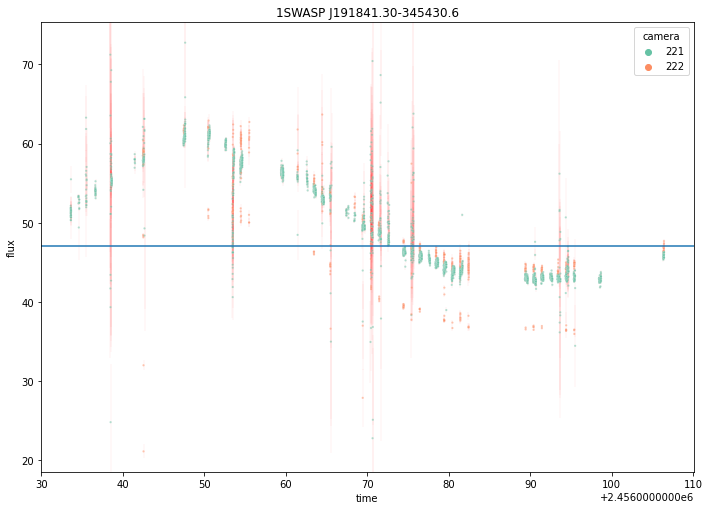

In [10]:
trimmed_timeseries = timeseries
if START_TIME > 0:
    START_TIME = Time(START_TIME / 86400 + 2453005.5, format='jd')
    trimmed_timeseries = trimmed_timeseries[trimmed_timeseries['time'] > START_TIME]
if END_TIME > 0:
    END_TIME = Time(END_TIME / 86400 + 2453005.5, format='jd')
    trimmed_timeseries = trimmed_timeseries[trimmed_timeseries['time'] < END_TIME]
if trimmed_timeseries is not timeseries:
    if SIGMA_CLIP > 0:
        trimmed_ts_flux = sigma_clip(trimmed_timeseries['TAMFLUX2'], sigma=SIGMA_CLIP)
    else:
        trimmed_ts_flux = trimmed_timeseries['TAMFLUX2']
    trimmed_ts_data = {
        'time': trimmed_timeseries.time.jd,
        'flux': trimmed_ts_flux,
        'err': trimmed_timeseries['TAMFLUX2_ERR'],
        'camera': trimmed_timeseries['CAMERA_ID'],
    }
    f, ax = pyplot.subplots(figsize=(11.7,8.27))
    seaborn.scatterplot(
        data=trimmed_ts_data,
        x='time',
        y='flux',
        alpha=0.5,
        s=5,
        palette='Set2',
        hue='camera',
    )
    lims = pyplot.ylim()
    pyplot.axhline(numpy.median(trimmed_ts_flux))

    pyplot.errorbar(trimmed_ts_data['time'], trimmed_ts_data['flux'], yerr=trimmed_ts_data['err'], ecolor='red', ls='none', zorder=-1, alpha=0.5, elinewidth=0.1)

    pyplot.ylim(lims)
    pyplot.title(SWASP_ID)

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Text(0.5, 1.0, '1SWASP J191841.30-345430.6')

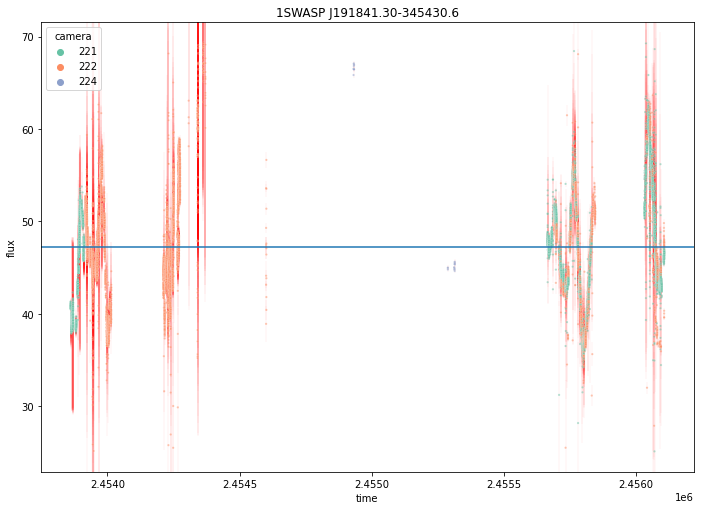

In [11]:
f, ax = pyplot.subplots(figsize=(11.7,8.27))
seaborn.scatterplot(
    data=ts_data,
    x='time',
    y='flux',
    alpha=0.5,
    s=5,
    palette='Set2',
    hue='camera',
)
lims = pyplot.ylim()
pyplot.axhline(numpy.median(ts_flux))

pyplot.errorbar(ts_data['time'], ts_data['flux'], yerr=ts_data['err'], ecolor='red', ls='none', zorder=-1, alpha=0.5, elinewidth=0.1)

pyplot.ylim(lims)
pyplot.title(SWASP_ID)

In [12]:
if FOLDING_PERIOD == 0:
    frequency, power = LombScargle(ts_data['time'], ts_data['flux'], ts_data['err']).autopower()
    periods = pandas.DataFrame({'frequency': frequency, 'power': power, 'period': (1/frequency)*86400}).sort_values('power', ascending=False)
else:
    ls = None
    periods = pandas.DataFrame({'frequency': 1, 'power': [1], 'period': 1})
periods.head(AUTO_FOLDED_PLOTS)


,frequency,power,period
156,0.013930,0.607107,6.202429e+06
157,0.014019,0.580102,6.163048e+06
150,0.013396,0.514502,6.449702e+06
11108,0.988765,0.484954,8.738174e+04
11422,1.016714,0.476712,8.497965e+04
151,0.013485,0.466706,6.407129e+06
163,0.014553,0.425723,5.936881e+06
11114,0.989299,0.413292,8.733457e+04
162,0.014464,0.413138,5.973416e+06
119,0.010637,0.400402,8.122846e+06


[None]

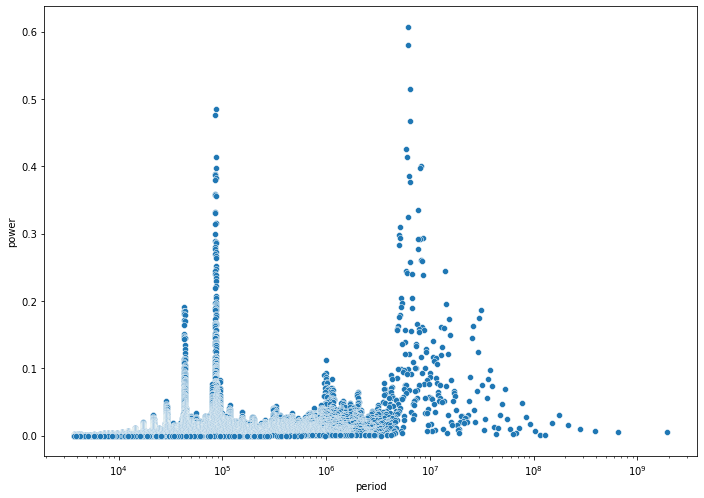

In [15]:
f, ax = pyplot.subplots(figsize=(11.7,8.27))
seaborn.scatterplot(data=periods, x='period', y='power').set(xscale="log")

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


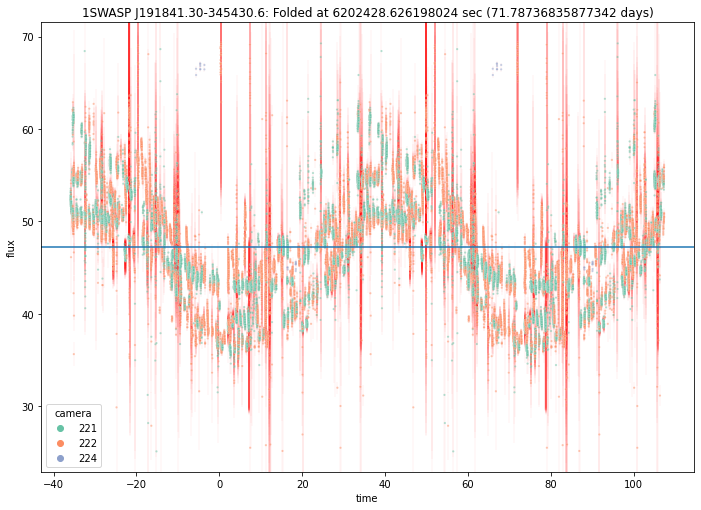

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


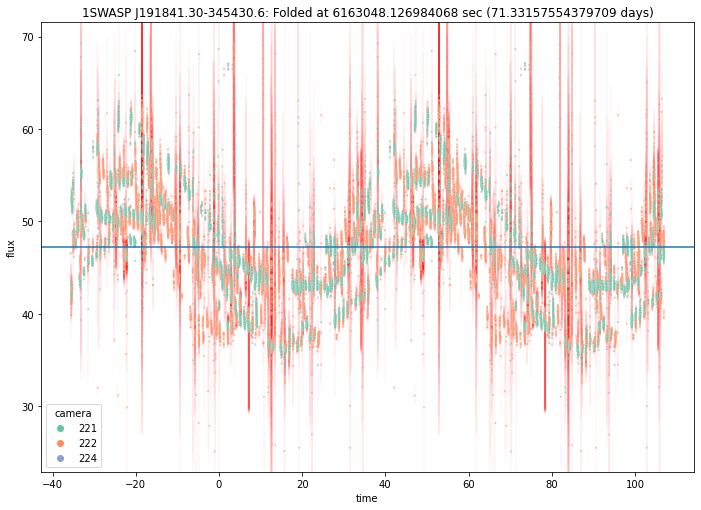

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


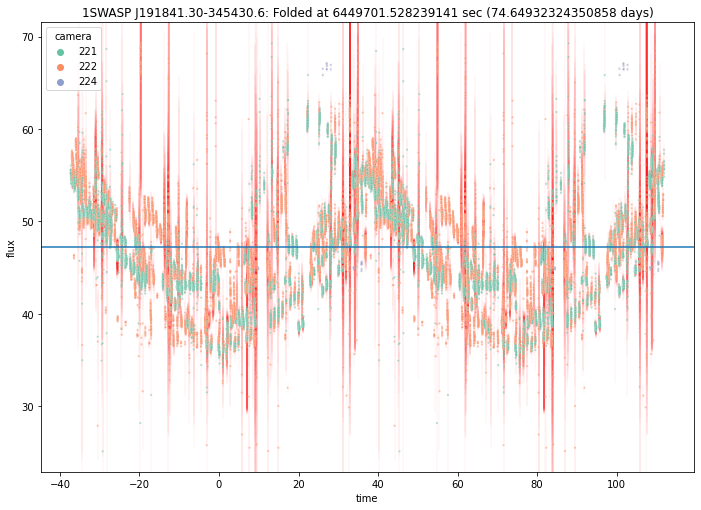

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


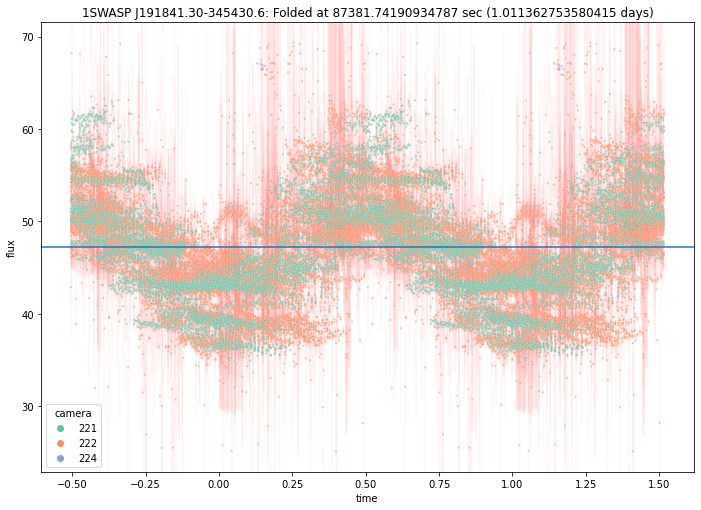

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


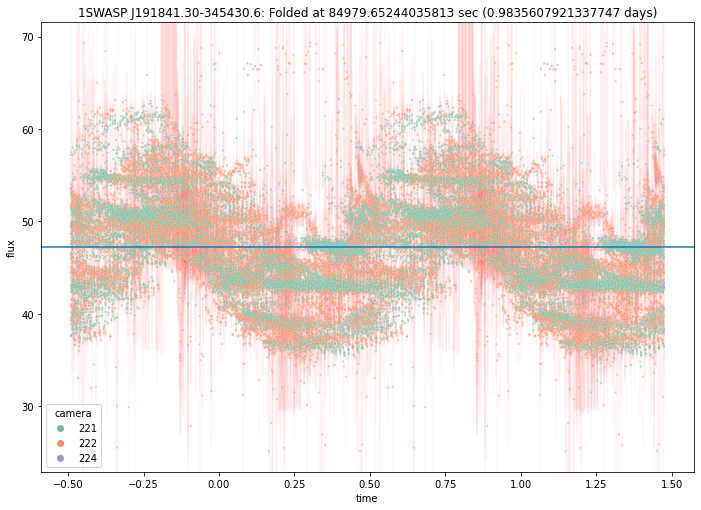

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


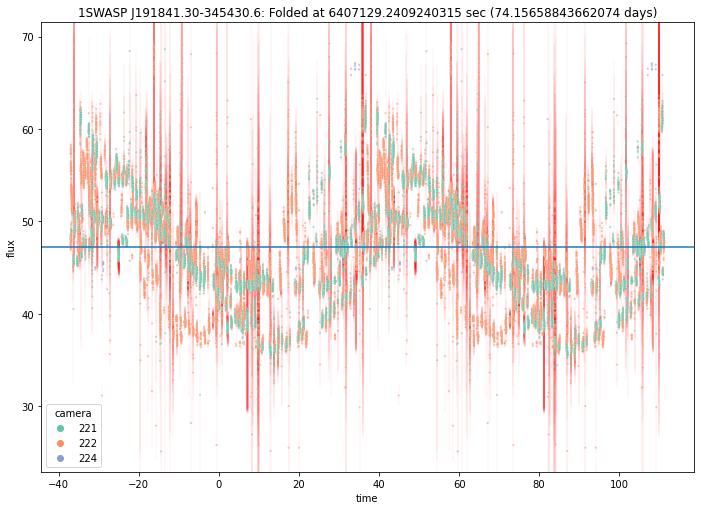

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


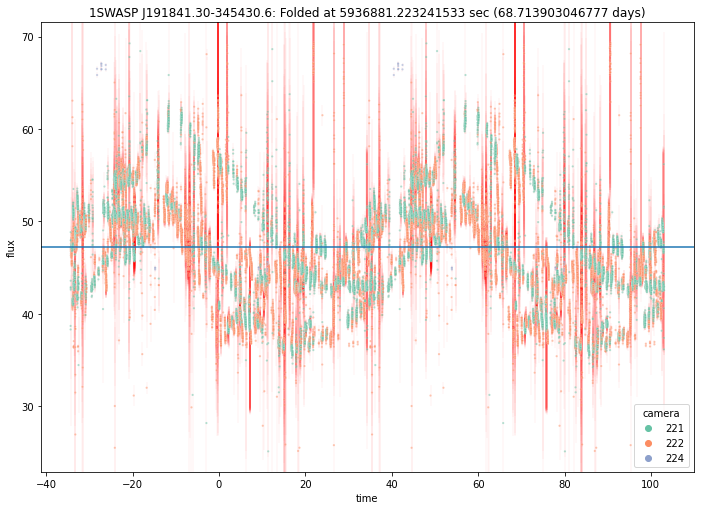

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


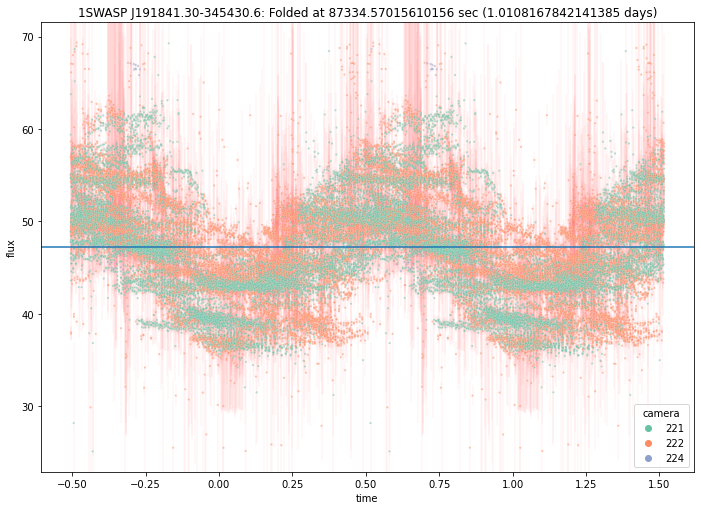

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


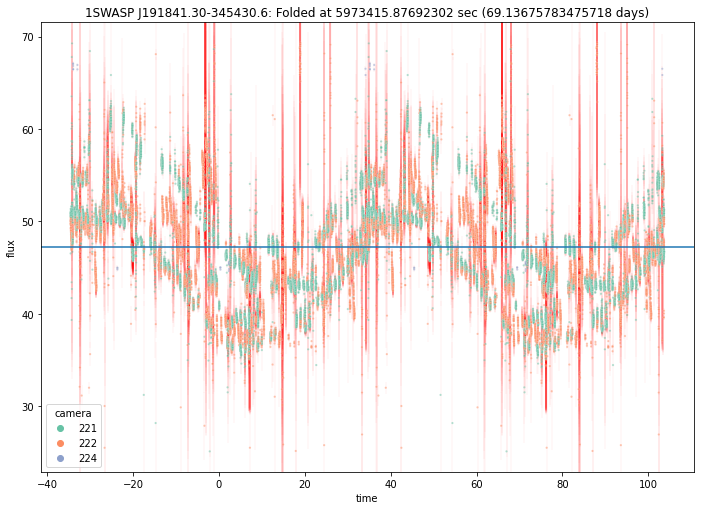

C:\Users\anm83\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


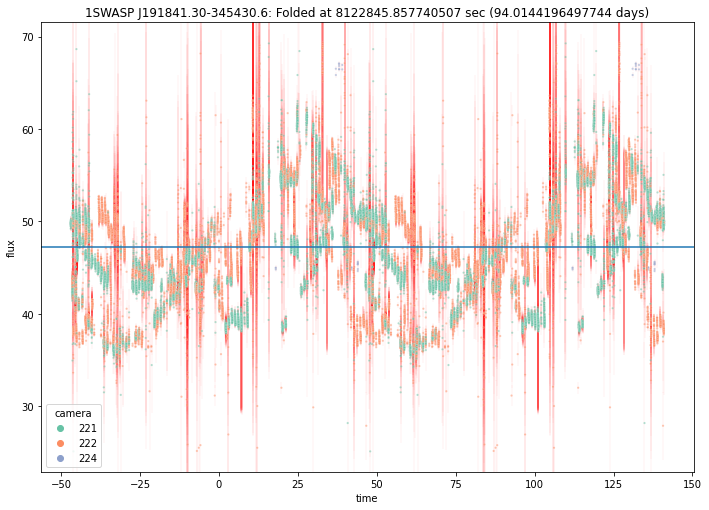

In [14]:
for i, period_row in periods.head(AUTO_FOLDED_PLOTS).iterrows():
    period = period_row['period']
    folded_ts_data = get_folded_ts(timeseries, period)
    f, ax = pyplot.subplots(figsize=(11.7,8.27))
    seaborn.scatterplot(
        data=folded_ts_data,
        x='time',
        y='flux',
        alpha=0.5,
        s=5,
        palette='Set2',
        hue='camera',
    )
    lims = pyplot.ylim()
    pyplot.axhline(numpy.median(folded_ts_data['flux']))

    pyplot.errorbar(folded_ts_data['time'], folded_ts_data['flux'], yerr=folded_ts_data['err'], ecolor='red', ls='none', zorder=-1, alpha=0.5, elinewidth=0.1)

    pyplot.ylim(lims)
    pyplot.title(f'{SWASP_ID}: Folded at {period} sec ({period/86400} days)')
    pyplot.show()